In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# custom
from reflectance import plotting, file_ops, optimisation_pipeline, spectrum_utils

In [2]:
results_fp = "/Users/rt582/Desktop/results_summary.csv"

import ast  # To convert string representations of lists to actual lists

# Define custom converters for list columns
def list_converter(val):
    try:
        return ast.literal_eval(val) if isinstance(val, str) else val
    except (ValueError, SyntaxError):
        return val

# Load CSV with correct data types
results_df = pd.read_csv(results_fp, 
                 header=[0,1],
                 parse_dates=[('metadata','datetime (UTC)')],  # Assuming 'metadata' is a datetime column in the multi-index
                 converters={
                     ('processing', 'nir_wavelengths'): list_converter,
                     ('processing', 'sensor_range'): list_converter,
                     ('processing', 'endmember_bounds'): list_converter,
                     ('processing', 'endmember_dimensionality_reduction'): list_converter,
                     ('fitting', 'bb_bounds'): list_converter,
                     ('fitting', 'Kd_bounds'): list_converter,
                     ('fitting', 'H_bounds'): list_converter,
                    ('simulation', 'Rb_vals'): list_converter,
                    ('simulation', 'depth_lims'): list_converter,
                    ('simulation', 'k_lims'): list_converter,
                    ('simulation', 'bb_lims'): list_converter,
                    ('simulation', 'noise_lims'): list_converter,
                     ('processing', 'endmember_source'): lambda x: x if x != 'None' else None,  # Convert 'None' strings to None
                     ('processing', 'save_fits'): lambda x: x == 'True',  # Convert to boolean
                 }
)

In [3]:
sub_df = results_df[results_df['fitting']['objective_fn'] == 'r2']
sub_df = results_df
best_row = sub_df.loc[sub_df['r2', 'mean'].idxmax()]
best_row.r2

# Initialize the dictionary
best_cfg_params_dict = {
    'processing': {},
    'simulation': {},
    'fitting': {}
}

for (level_0, level_1) in best_row.index:
    value = best_row[(level_0, level_1)]
    if level_0 in best_cfg_params_dict:
        if not isinstance(value, list):
            value = None if pd.isna(value) else value
            
        best_cfg_params_dict[level_0][level_1] = value

In [9]:
# run pipeline with cfg
g_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
g_cfg.save_fits = True
cfg = file_ops.RunOptPipeConfig(best_cfg_params_dict)

pipe = optimisation_pipeline.OptPipe(g_cfg, cfg)
fit_results = pipe.run()

Fitting spectra:   0%|          | 0/1938 [00:00<?, ?it/s]

RunOptPipeConfig(processing={'endmember_source': 'spectral_library', 'aop_group_num': 1, 'nir_wavelengths': [750, 1100], 'sensor_range': [450, 690], 'endmember_dimensionality_reduction': ['pca', 1], 'endmember_normalisation': None, 'endmember_class_schema': 'three_endmember', 'spectra_normalisation': None}, fitting={'Rb_init': 0.5, 'endmember_bounds': '[0, 1]', 'objective_fn': 'r2', 'bb_bounds': (0, 0.41123), 'Kd_bounds': (0.01688, 1.5), 'H_bounds': (0, 10), 'solver': 'CG', 'tol': 1e-12}, simulation={'type': 'spread', 'N': 100, 'Rb_vals': (0, 1), 'n_depths': 10, 'depth_lims': (0, 10), 'n_ks': 10, 'k_lims': (0, 0.4), 'n_bbs': 10, 'bb_lims': (0.01, 0.03), 'n_noise_levels': 10, 'noise_lims': (0.001, 0), 'noise_ind': 0}, aop_group_num=1, nir_wavelengths=[750, 1100], sensor_range=[450, 690], endmember_source='spectral_library', endmember_dimensionality_reduction=['pca', 1], endmember_normalisation=None, endmember_class_schema='three_endmember', spectra_normalisation=None, objective_fn='r2',

In [21]:
fit_fp = "/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/results/fits/fit_results_1.csv"
fits = pd.read_csv(fit_fp, header=[0,1])
fits.fitted_params.head()

,bb,K,H,"('algae', 'PCA_1')","('coral', 'PCA_1')","('sand', 'PCA_1')"
0,0.385805,0.705707,3.395330,0.683437,0.277242,0.637802
1,0.390605,0.705111,3.385995,0.676781,0.322097,0.581538
2,0.354320,0.663175,3.427786,0.672484,0.312580,0.499252
3,0.394862,0.707063,3.497552,0.649563,0.371698,0.559219
4,0.400822,0.733364,3.354579,0.651350,0.323828,0.652869


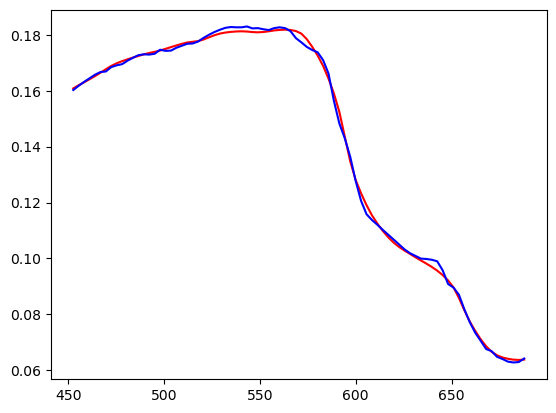

In [40]:
plt.plot(fits.fitted_spectra.iloc[0], c="r")
plt.plot(prism_spectra.iloc[0], c="b")
# true_spectrum = prism_spectra.iloc[0,:]

# plt.plot(true_spectrum, c="g")

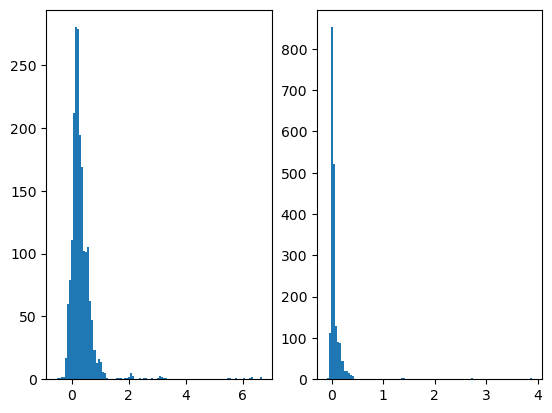

In [22]:
fig, ax = plt.subplots(1,2)

ax[0].hist(fits.fitted_params.K, bins=100);
ax[1].hist(fits.fitted_params.bb, bins=100);

In [23]:
fit_results

fitted_params                                                     \
                bb         K          H (algae, PCA_1) (coral, PCA_1)   
0         0.385805  0.705707    3.39533       0.683437       0.277242   
1         0.390605  0.705111   3.385995       0.676781       0.322097   
2         0.354320  0.663175   3.427786       0.672484        0.31258   
3         0.394862  0.707063   3.497552       0.649563       0.371698   
4         0.400822  0.733364   3.354579        0.65135       0.323828   
...            ...       ...        ...            ...            ...   
1933      0.052057  0.283238  12.841902       -0.93362      -0.639212   
1934      0.050987  0.305306  12.591032      -0.936692      -0.583761   
1935      0.046227  0.296045  10.923569       -0.55141      -0.266833   
1936      0.048902  0.268991  12.149778      -0.207298      -0.246128   
1937      0.049705  0.254916  13.349138       0.029718      -0.176467   

                   fitted_spectra                                   ...  \
     (sand, PCA_1)     452.642775 455.475056 458.307394 461.139788  ...   
0         0.637802       0.160828   0.162001   0.163048   0.164121  ...   
1         0.581538       0.160381    0.16152   0.162533   0.163575  ...   
2         0.499252       0.150419   0.151466   0.152392   0.153343  ...   
3         0.559219       0.162043    0.16317   0.164175   0.165213  ...   
4         0.652869       0.162576   0.163761   0.164819   0.165907  ...   
...            ...            ...        ...        ...        ...  ...   
1933      1.996946        0.07234   0.072732   0.073121    0.07365  ...   
1934      2.289718       0.076645    0.07723   0.077799   0.078523  ...   
1935      2.173379       0.086041   0.086853   0.087613   0.088545  ...   
1936      1.439426       0.077959    0.07858   0.079165   0.079887  ...   
1937      1.128324       0.078074   0.078686   0.079264   0.079975  ...   

                                                              metrics  \
     676.566275 679.402999 682.239779 685.076616 687.913509        r2   
0      0.064561   0.064084   0.063774   0.063667   0.063801  0.999001   
1      0.064657   0.064201   0.063937   0.063906   0.064148  0.998845   
2       0.05971   0.059281   0.059043   0.059036   0.059288  0.998875   
3      0.064187   0.063732   0.063458   0.063409   0.063628  0.999006   
4       0.06621   0.065752   0.065483   0.065446   0.065686  0.998873   
...         ...        ...        ...        ...        ...       ...   
1933   0.008978   0.008831   0.008634   0.008387     0.0081   0.99836   
1934   0.008821   0.008675   0.008479   0.008233   0.007947  0.998927   
1935   0.008584   0.008425   0.008211   0.007942   0.007629  0.998957   
1936   0.008666    0.00852   0.008325   0.008083   0.007801  0.998797   
1937   0.008703   0.008561   0.008374   0.008141    0.00787  0.998787   

                                                           
     spectral_angle      rmse mean_abs_dev median_abs_dev  
0          0.009067  0.001341     0.001039       0.000812  
1          0.009684   0.00143     0.001108       0.000847  
2          0.009643  0.001331     0.001035       0.000908  
3          0.009126  0.001356     0.001066       0.000765  
4           0.00952  0.001431     0.001069       0.000829  
...             ...       ...          ...            ...  
1933       0.021875  0.001053      0.00087       0.000778  
1934       0.017886  0.000944     0.000804       0.000712  
1935       0.017751  0.001114     0.000927       0.000902  
1936       0.018793  0.001038     0.000867       0.000843  
1937       0.018924   0.00104      0.00086       0.000746  

[1938 rows x 95 columns]

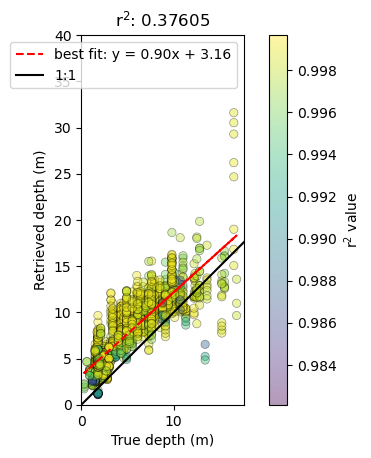

In [24]:
from sklearn.metrics import r2_score
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data_v2.csv")


fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth[:len(fit_results)], fit_results.fitted_params["H"], alpha=0.4, c=fit_results.metrics.r2, edgecolor='k', lw=0.5)

# calculate fit_results
p = np.polyfit(validation_data.Depth[:len(fit_results)], fit_results.fitted_params["H"].astype(float), 1)
pred = np.polyval(p, validation_data.Depth[:len(fit_results)])
r2 = r2_score(validation_data.Depth[:len(fit_results)], pred)
ax.plot(validation_data.Depth[:len(fit_results)], pred, color='r', ls='--', label="best fit: y = {:.2f}x + {:.2f}".format(*p))
# formatting
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=40)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth (m)")
ax.set_ylabel("Retrieved depth (m)")
ax.set_aspect('equal')
fig.colorbar(ma, label="r$^2$ value")
ax.legend()

In [46]:
best_cfg_params_dict["processing"]["endmember_dimensionality_reduction"]

['pca', 1]

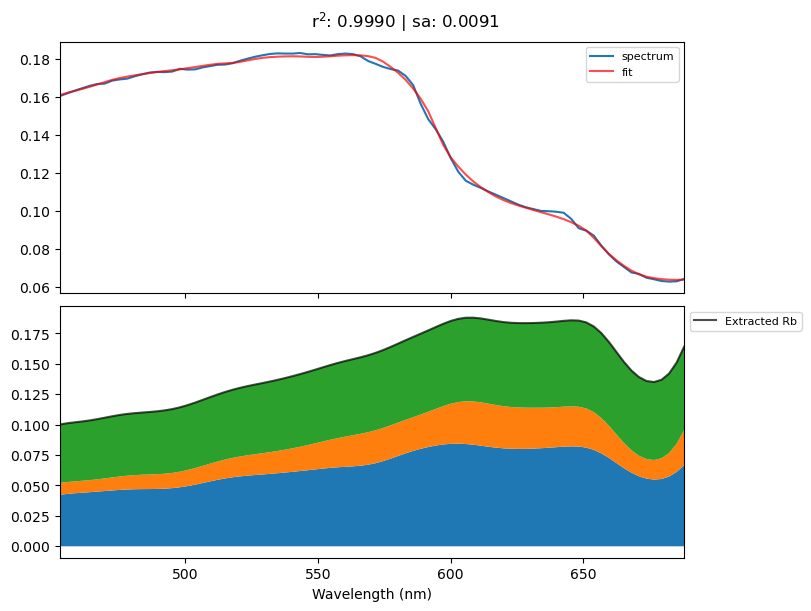

In [83]:
i = 0

fits = fit_results

AOP_model = spectrum_utils.load_aop_model(aop_group_num=1).loc[spectrum_utils.SENSOR_RANGE[0]:spectrum_utils.SENSOR_RANGE[1]]
wvs = AOP_model.index
AOP_sub = AOP_model.loc[wvs]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)

# read in spectral library
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)

# generate endmembers
endmember_class_schema = best_row.processing["endmember_class_schema"]
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
# generate endmember array
endmember_array = optimisation_pipeline.GenerateEndmembers(
    endmember_class_map=glob_cfg.endmember_schema[endmember_class_schema],
    endmember_dimensionality_reduction=best_cfg_params_dict["processing"]["endmember_dimensionality_reduction"],
).generate_endmembers()
# crop to sensor range
endmember_array = endmember_array.loc[:,spectrum_utils.SENSOR_RANGE[0]:spectrum_utils.SENSOR_RANGE[1]]

prism_spectra = spectrum_utils.preprocess_prism_spectra(spectrum_utils.load_spectra())
fit = fits.iloc[i,:3+len(endmember_array)]
true_spectrum = prism_spectra.iloc[i,:]
# plot problem fits
plotting.plot_single_fit(fit, true_spectrum, AOP_args, endmember_array, endmember_array.index)

In [101]:
validation_data = pd.read_csv(
            file_ops.DATA_DIR_FP / "CORAL_validation_data.csv"
        )
validation_data.columns

Index(['X', 'Y', 'Campaign', 'Locale', 'Station', 'TimeUTC', 'TimeLocal',
       'Depth', 'Metabolism', 'Optics', 'Comments', 'algCCA', 'algCyano',
       'algMacBrn', 'algMacGrn', 'algMacMix', 'algMacRed', 'algMacUnk',
       'algTurf', 'crlCoral', 'crlBleach', 'othOcto', 'othSeagr', 'othClam',
       'othInvert', 'othOther', 'othSponge', 'othUrchin', 'sedLimest',
       'sedMud', 'sedRubble', 'sedSand', 'ROInumber', 'Flightline'],
      dtype='object')

In [103]:
validation_data = spectrum_utils.map_validation(validation_data, g_cfg.__dict__["endmember_map"])
endmember_class_schema = "three_endmember"
endmember_schema_map = g_cfg.__dict__["endmember_schema"][endmember_class_schema]
grouped_val_data = pd.DataFrame()
# group validation data by endmember categories in endmember_schema_map
for (endmember_dimensionality_reduction, validation_fields) in endmember_schema_map.items():
    # fill in validation data with sum of all fields in the category
    
    grouped_val_data[endmember_dimensionality_reduction] = validation_data[
        validation_fields
    ].sum(axis=1)
    

# normalise grouped_val_data along rows
grouped_val_data = grouped_val_data.div(grouped_val_data.sum(axis=1), axis=0)


,algae,coral,sand
0,0.720000,0.010000,0.270000
1,0.720000,0.010000,0.270000
2,0.720000,0.010000,0.270000
3,0.720000,0.010000,0.270000
4,0.720000,0.010000,0.270000
5,0.720000,0.010000,0.270000
6,0.720000,0.010000,0.270000
7,0.720000,0.010000,0.270000
8,0.720000,0.010000,0.270000
9,0.904255,0.042553,0.053191


In [116]:
# normalise fit param results
fit_params = fits.fitted_params.iloc[:,3:]
# normalise fit_params along rows
norm_benthic_fit_params = fit_params.div(fit_params.sum(axis=1), axis=0)

In [125]:
grouped_val_data

,algae,coral,sand
0,0.720000,0.010000,0.270000
1,0.720000,0.010000,0.270000
2,0.720000,0.010000,0.270000
3,0.720000,0.010000,0.270000
4,0.720000,0.010000,0.270000
...,...,...,...
1933,0.602041,0.367347,0.030612
1934,0.602041,0.367347,0.030612
1935,0.505051,0.484848,0.010101
1936,0.505051,0.484848,0.010101


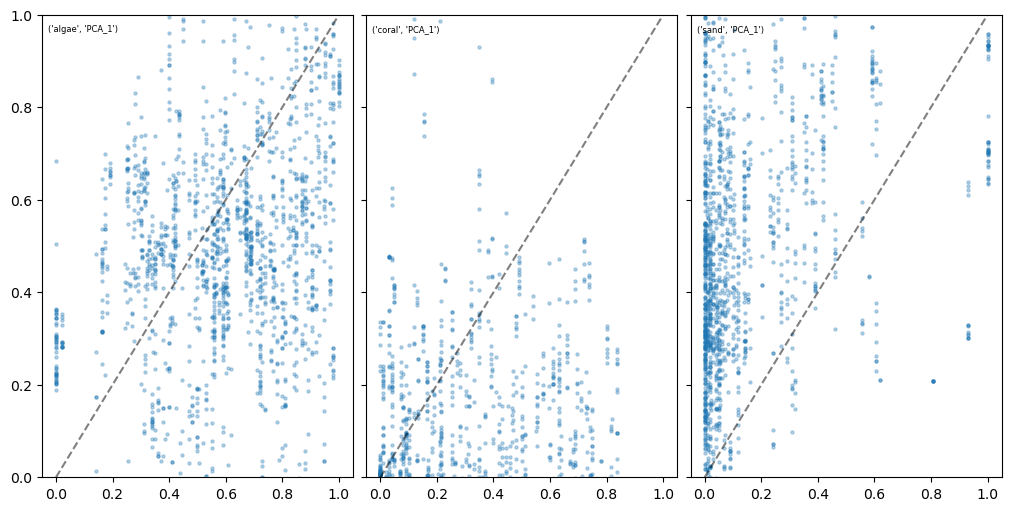

In [129]:
# plot retrieved endmembers against true endmembers
fig, axs = plt.subplots(1, 3, figsize=[10, 5], sharex=True, sharey=True, constrained_layout=True)


for endmember, ax in zip(norm_benthic_fit_params.columns, axs.flat):
    # print(endmember[0])
    ax.scatter(grouped_val_data[endmember[0]], norm_benthic_fit_params[endmember], s=5, alpha=0.3)
    ax.text(0.02, 0.98, endmember, ha='left', va='top', transform=ax.transAxes, fontsize=6)
    # ax.axis('square')
    ax.plot([0,1], [0,1], color='k', ls='--', alpha=0.5)
    ax.set_ylim(0, 1)